In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [2]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [3]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [4]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


In [32]:
y_train.shape, y_test.shape

((560, 10), (140, 10))

In [45]:
id2cell = {i:label for i, label in enumerate(categories)}
cell2id = {label:i for i, label in id2cell.items()}
id_labels = df['bulk_labels'].map(cell2id).to_numpy().astype(np.uint8)
y_id = id_labels[permutation]

y_id_train = y_id[:int(len(y_id)*0.8)]
y_id_test = y_id[int(len(y_id)*0.8):]

In [43]:
keys = np.array(list(id2cell.keys()))
values = np.array(list(id2cell.values()))
train_index = np.searchsorted(keys, y_id_train)
test_index = np.searchsorted(keys, y_id_test)

train_labels = df['bulk_labels'].values[permutation][:int(len(y_id)*0.8)]
test_labels = df['bulk_labels'].values[permutation][int(len(y_id)*0.8):]
print(np.all(values[train_index] == train_labels))
print(np.all(values[test_index] == test_labels))

True
True


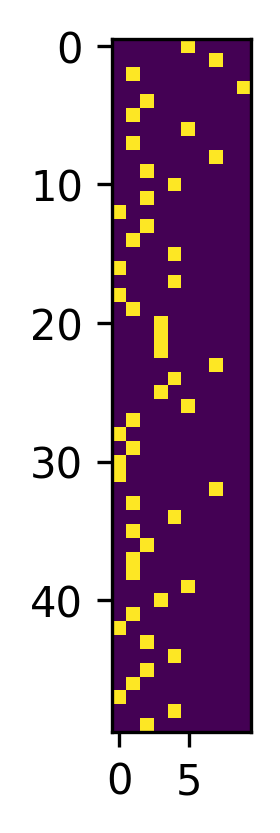

In [5]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [6]:
from models.autoencoder import MLP, PBMCAutoEncoder
from configs import get_config

In [7]:
config = get_config("final_autoencoder.config")

In [8]:
encoder = MLP(765, config['num_hidden_layers'], config['latent_dim'])
decoder = MLP(config['latent_dim'], config['num_hidden_layers'], 765)
model = PBMCAutoEncoder(encoder, decoder)

In [9]:
model.load_state_dict(torch.load("models/final_model.pt", weights_only=True))
model.eval()

PBMCAutoEncoder(
  (encoder): MLP(
    (hidden_layers): Sequential()
    (out_layer): Linear(in_features=765, out_features=64, bias=True)
  )
  (decoder): MLP(
    (hidden_layers): Sequential()
    (out_layer): Linear(in_features=64, out_features=765, bias=True)
  )
)

In [10]:
model.encoder.state_dict()

OrderedDict([('out_layer.weight',
              tensor([[-0.0002, -0.0208, -0.0687,  ...,  0.0175, -0.0109, -0.0444],
                      [-0.0232, -0.0067, -0.0143,  ..., -0.0054, -0.0166,  0.0332],
                      [-0.0043, -0.0222,  0.0171,  ..., -0.0092, -0.0395, -0.0220],
                      ...,
                      [-0.0173, -0.0177, -0.0127,  ...,  0.0058,  0.0080, -0.0089],
                      [ 0.0309,  0.0373, -0.0383,  ..., -0.0086, -0.0108,  0.0171],
                      [-0.0270,  0.0065, -0.0015,  ...,  0.0112,  0.0059, -0.0227]])),
             ('out_layer.bias',
              tensor([-0.0119,  0.0049, -0.0220,  0.0196,  0.0244,  0.0152, -0.0097,  0.0014,
                      -0.0152,  0.0095,  0.0361,  0.0130,  0.0180,  0.0084,  0.0087,  0.0017,
                       0.0212, -0.0149,  0.0115, -0.0073,  0.0260,  0.0077, -0.0022,  0.0242,
                      -0.0086,  0.0079,  0.0218,  0.0317, -0.0128,  0.0018, -0.0054,  0.0055,
                      -0

In [11]:
encoder.load_state_dict(model.encoder.state_dict())
encoder.eval()

<All keys matched successfully>

In [12]:
X_train.astype(np.float32)

array([[-0.326, -0.191, -0.728, ..., -0.21 , -0.636, -0.49 ],
       [-0.326, -0.191, -0.728, ..., -0.21 ,  2.134, -0.49 ],
       [-0.326, -0.191,  0.32 , ..., -0.21 , -0.636, -0.49 ],
       ...,
       [ 3.762, -0.191,  0.658, ...,  1.355, -0.636, -0.49 ],
       [ 1.006, -0.191,  1.981, ..., -0.21 ,  0.816, -0.49 ],
       [-0.326, -0.191,  1.887, ..., -0.21 ,  0.766,  1.343]],
      shape=(560, 765), dtype=float32)

In [13]:
torch_X_train = torch.from_numpy(X_train.astype(np.float32))

In [19]:
with torch.no_grad():
    embeddings = encoder(torch_X_train)
embeddings

tensor([[ 1.3229,  0.6660, -0.0110,  ..., -0.0560, -1.8614,  0.8800],
        [-0.2037, -1.1403, -0.8262,  ..., -0.1985, -0.2177, -1.2146],
        [ 0.5766,  0.9884,  0.3199,  ..., -1.0445, -0.4503,  0.1361],
        ...,
        [ 0.6529,  0.1163, -0.9446,  ..., -0.9069,  1.0757, -0.6656],
        [-0.4747, -0.0938, -0.4362,  ..., -0.6411, -1.3969, -0.7539],
        [ 0.7206, -0.4270,  0.1024,  ...,  1.0023, -0.6844, -0.5721]])

Classification methods to try: (based on map from: https://scikit-learn.org/stable/machine_learning_map.html)
1) Linear SVC
2) KNeighbours classification
3) SVC
4) Ensemble Methods

- Neural net?? 

### LinearSVC

In [89]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, classification_report, RocCurveDisplay

In [88]:
lin_svc = LinearSVC(penalty='l2', random_state=42, tol=1e-5)
lin_svc.fit(X_train, y_id_train)
predictions = lin_svc.predict(X_test)

In [63]:
print(classification_report(y_id_test, predictions, target_names=categories, zero_division=np.nan))

                              precision    recall  f1-score   support

              CD14+ Monocyte       0.82      0.90      0.86        30
                   Dendritic       0.94      0.92      0.93        50
                    CD56+ NK       1.00      0.50      0.67         6
             CD4+/CD25 T Reg       0.54      0.70      0.61        10
                     CD19+ B       1.00      0.87      0.93        15
            CD8+ Cytotoxic T       0.80      0.86      0.83        14
         CD4+/CD45RO+ Memory       0.50      1.00      0.67         1
CD8+/CD45RA+ Naive Cytotoxic       0.78      0.78      0.78         9
  CD4+/CD45RA+/CD25- Naive T        nan      0.00      0.00         2
                       CD34+       1.00      1.00      1.00         3

                    accuracy                           0.85       140
                   macro avg       0.82      0.75      0.73       140
                weighted avg       0.87      0.85      0.85       140



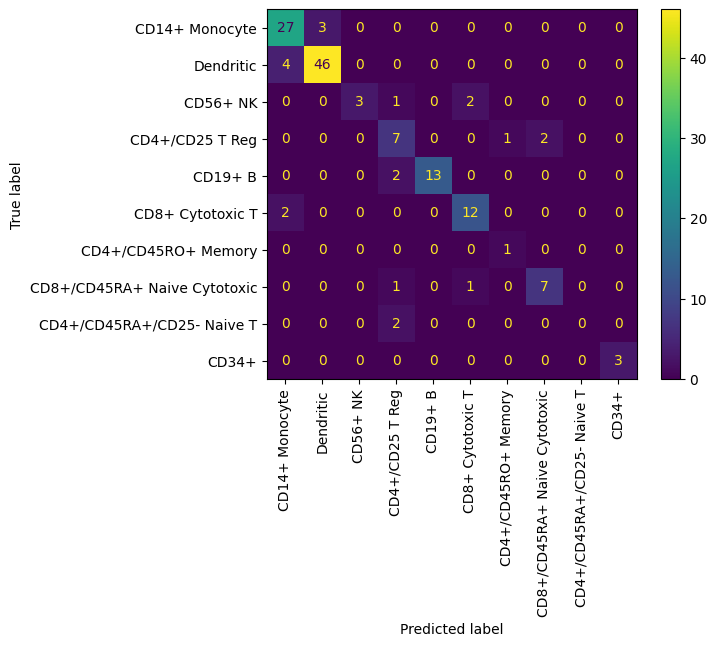

In [93]:
ConfusionMatrixDisplay.from_predictions(y_id_test, predictions, display_labels=categories, xticks_rotation='vertical')

#### random shit

In [71]:
preds_one_hot = np.zeros((predictions.size, 10))
preds_one_hot[np.arange(predictions.size), predictions] = 1
preds_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(140, 10))

In [100]:
pred_probs = lin_svc.decision_function(X_test)
pred_probs

array([[-1.40195163,  2.50353257, -0.83611163, ..., -0.78347295,
        -1.0436791 , -0.75432132],
       [-0.81069038,  1.63720573, -0.50310522, ..., -0.40566826,
        -0.92201397, -0.88298015],
       [-1.71887253, -0.33962443, -0.0122382 , ..., -0.72746881,
         0.13759006, -0.52495314],
       ...,
       [-1.06760089, -0.6070445 , -0.04631191, ..., -0.24827709,
        -0.72793051, -0.3923376 ],
       [ 1.3880643 , -1.11994243, -1.31410943, ..., -0.57924815,
        -0.78940655, -1.0910561 ],
       [-0.42678032, -1.12362685, -0.38347958, ...,  0.06468142,
        -0.40140516, -0.10964149]], shape=(140, 10))

In [81]:
class_of_interest = "CD14+ Monocyte"
class_id = np.zeros(10)
class_id[cell2id[class_of_interest]] = 1
class_id

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

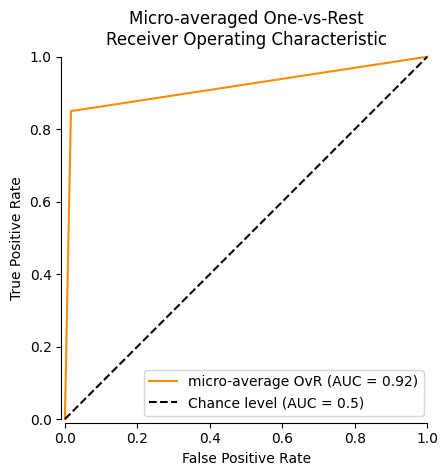

In [74]:
display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    preds_one_hot.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [84]:
fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds_one_hot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [85]:
fpr

{'micro': array([0.        , 0.01666667, 1.        ])}

### SVC

In [97]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_id_train)
svc_predictions = svc.predict(X_test)

In [98]:
print(classification_report(y_id_test, svc_predictions, target_names=categories, zero_division=np.nan))

                              precision    recall  f1-score   support

              CD14+ Monocyte       0.75      0.90      0.82        30
                   Dendritic       0.91      0.86      0.89        50
                    CD56+ NK       1.00      0.50      0.67         6
             CD4+/CD25 T Reg       0.43      1.00      0.61        10
                     CD19+ B       1.00      0.87      0.93        15
            CD8+ Cytotoxic T       0.54      0.50      0.52        14
         CD4+/CD45RO+ Memory        nan      0.00      0.00         1
CD8+/CD45RA+ Naive Cytotoxic       1.00      0.33      0.50         9
  CD4+/CD45RA+/CD25- Naive T        nan      0.00      0.00         2
                       CD34+       1.00      0.67      0.80         3

                    accuracy                           0.77       140
                   macro avg       0.83      0.56      0.57       140
                weighted avg       0.83      0.77      0.76       140



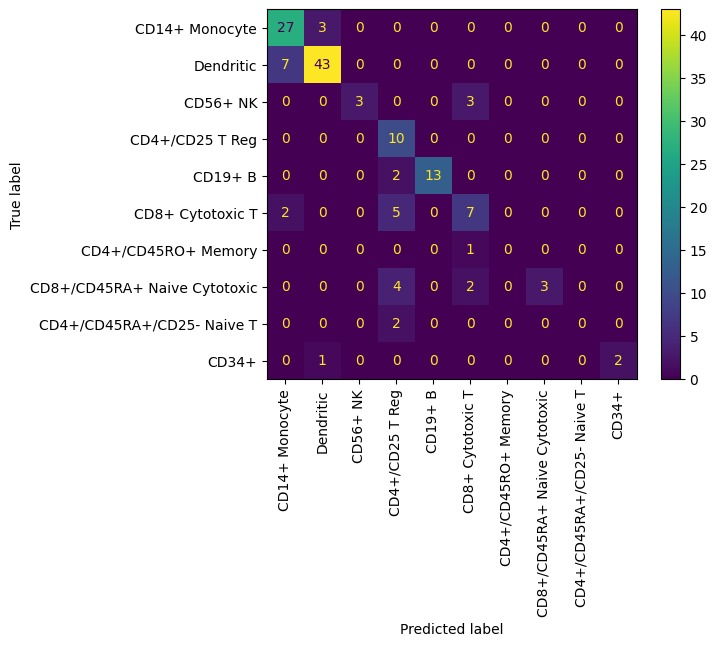

In [96]:
ConfusionMatrixDisplay.from_predictions(y_id_test, svc_predictions, display_labels=categories, xticks_rotation='vertical')